# **Importing Data**

In [1]:
# Extract ZIP Files
import zipfile
with zipfile.ZipFile('/content/neudefectdataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/neudataset')

# **Import Libraries**

In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from keras.applications.efficientnet import EfficientNetB0
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras import optimizers

# **Data Preprocessing**

In [3]:
# Load data
dir = '/content/neudataset/neudefectdataset'
data = pd.read_csv('/content/CSVNEU224.csv')

image_filenames = data['image'].values
labels = data['label'].values

images = []
for filename, label in zip(image_filenames, labels):
    image_path = os.path.join(dir, label, filename)
    image = cv2.imread(image_path)
    if image is not None:
        images.append(image)
    else:
        print(f"Failed to load image: {image_path}")

images = np.array(images)
labels = np.array(labels)

print(images.shape)
print(labels.shape)

(1800, 224, 224, 3)
(1800,)


In [4]:
# Transform string labels into numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

X_subset, X_test, y_subset, y_test = train_test_split(images, labels, test_size=0.15, random_state=42, shuffle=True)

Label Mapping: {'Crazing': 0, 'Inclusions': 1, 'Patches': 2, 'Pitted': 3, 'Rolled': 4, 'Scratches': 5}


# **Data Visualization**

5


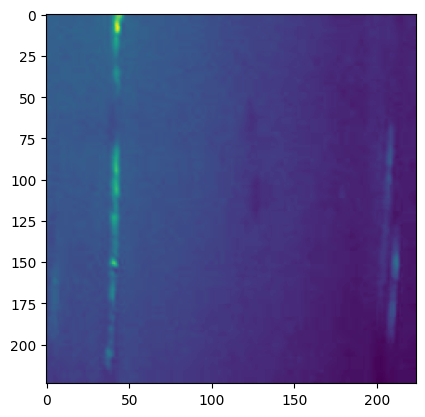

In [5]:
plt.imshow(X_test[100][:,:,0])
print(y_test[100])

In [6]:
print(X_subset.shape)
print(X_test.shape)
print(y_subset.shape)
print(y_test.shape)

(1530, 224, 224, 3)
(270, 224, 224, 3)
(1530,)
(270,)


# **Model development**

In [7]:
batch_size = 64
num_classes = 6
epochs = 15
input_shape = (224,224,3)

In [8]:
# Learning rates for the grid search
learning_rates = [0.01, 0.001, 0.0001]

# List to store the trained models
trained_models = []

# Stratified K Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store all performance metrics
all_accuracies = []
all_tp_rates = []
all_ppv_values = []

all_fold_accuracies = []
all_fold_tp_rates = []
all_fold_ppv_values = []

# Perform grid search
for lr in learning_rates:
    # Lists to store performance metrics for each fold
    accuracies = []
    tp_rates = []
    ppv_values = []

    for fold, (train, val) in enumerate(skf.split(X_subset, y_subset), start=1):
      X_tr = X_subset[train]
      y_tr = y_subset[train]
      X_val = X_subset[val]
      y_val = y_subset[val]

      encoder = OneHotEncoder()
      y_subset_encoded = encoder.fit_transform(y_subset.reshape(-1, 1)).toarray()

      y_tr = y_subset_encoded[train]  # One hot vectors
      y_val = y_subset_encoded[val]   # One hot vectors

      # Print the fold number and learning rate
      print(f"Fold {fold}, Learning Rate: {lr}")

      # Model architecture + Transfer Learning
      efficientnetb0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

      for layer in efficientnetb0.layers:
          layer.trainable = False

      x = Flatten()(efficientnetb0.output)
      x = Dense(128, activation='relu')(x)
      x = Dropout(0.2)(x)
      x = Dense(64, activation='relu')(x)
      output = Dense(num_classes, activation='softmax')(x)
      model = Model(inputs=efficientnetb0.input, outputs=output)

      model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics=['accuracy'])
      model.fit(X_tr, y_tr, validation_data=(X_val, y_val),
                batch_size=batch_size, epochs=epochs)

      # Evaluate the model on validation data
      y_pred = model.predict(X_val)

      y_pred_classes = np.argmax(y_pred, axis=1)
      y_val_categorical = np.argmax(y_val, axis=1)

      # Calculate accuracy, precision, and recall
      accuracy = accuracy_score(y_val_categorical, y_pred_classes)
      precision = precision_score(y_val_categorical, y_pred_classes, average='macro')
      recall = recall_score(y_val_categorical, y_pred_classes, average='macro')

      # Store accuracy, recall, and precision values
      accuracies.append(accuracy)
      tp_rates.append(recall)
      ppv_values.append(precision)

      # All folds
      all_fold_accuracies.append(accuracy)
      all_fold_tp_rates.append(recall)
      all_fold_ppv_values.append(precision)

      # Store trained models
      trained_models.append(model)

    # Calculate the average and standard deviation of evaluation metrics
    average_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    average_tp_rate = np.mean(tp_rates, axis=0)
    std_tp_rate = np.std(tp_rates, axis=0)

    average_ppv = np.mean(ppv_values, axis=0)
    std_ppv = np.std(ppv_values, axis=0)

    # Store all values
    all_accuracies.append(average_accuracy)
    all_tp_rates.append(average_tp_rate)
    all_ppv_values.append(average_ppv)

    # Print or store the average and standard deviation of evaluation metrics
    print("Average Accuracy:", average_accuracy)
    print("Standard Deviation of Accuracy:", std_accuracy)

    print("Average Recall:", average_tp_rate)
    print("Standard Deviation of Recall:", std_tp_rate)

    print("Average Positive Precision:", average_ppv)
    print("Standard Deviation of Precision:", std_ppv)

Fold 1, Learning Rate: 0.01
Epoch 1/15
20/20 [==============================] - 21s 332ms/step - loss: 28.7953 - accuracy: 0.5458 - val_loss: 1.1131 - val_accuracy: 0.9248
Epoch 2/15
20/20 [==============================] - 3s 145ms/step - loss: 1.5206 - accuracy: 0.8897 - val_loss: 0.0597 - val_accuracy: 0.9869
Epoch 3/15
20/20 [==============================] - 3s 144ms/step - loss: 0.4363 - accuracy: 0.9526 - val_loss: 0.2659 - val_accuracy: 0.9771
Epoch 4/15
20/20 [==============================] - 3s 141ms/step - loss: 0.1373 - accuracy: 0.9804 - val_loss: 0.1977 - val_accuracy: 0.9837
Epoch 5/15
20/20 [==============================] - 3s 146ms/step - loss: 0.1889 - accuracy: 0.9739 - val_loss: 0.1849 - val_accuracy: 0.9739
Epoch 6/15
20/20 [==============================] - 3s 148ms/step - loss: 0.0878 - accuracy: 0.9820 - val_loss: 0.1318 - val_accuracy: 0.9837
Epoch 7/15
20/20 [==============================] - 3s 141ms/step - loss: 0.1662 - accuracy: 0.9779 - val_loss: 0.2193

In [9]:
# Print all the stored performance metric values for all folds and learning rate values
# Evaluated on VALIDATION DATA

print("All Accuracies:", all_fold_accuracies)
print("All Avg TP Rates:", all_fold_tp_rates)
print("All Avg PPV Values:", all_fold_ppv_values)

All Accuracies: [0.9869281045751634, 0.9803921568627451, 0.9869281045751634, 0.9836601307189542, 0.9803921568627451, 0.9901960784313726, 0.9771241830065359, 0.9934640522875817, 0.9901960784313726, 1.0, 1.0, 0.9901960784313726, 0.9967320261437909, 0.9901960784313726, 1.0]
All Avg TP Rates: [0.9871794871794872, 0.980580693815988, 0.987174744111481, 0.9833254840397697, 0.9803216158258176, 0.9903217697335345, 0.9774384112619408, 0.9935873720557405, 0.9899999999999999, 1.0, 1.0, 0.9902589240824535, 0.9968553459119497, 0.9899999999999999, 1.0]
All Avg PPV Values: [0.9875378523177266, 0.9804524886877829, 0.9872912127814089, 0.9844491927825261, 0.9811812189263169, 0.9904450895016933, 0.9780319535221497, 0.9936502177068215, 0.9909090909090909, 1.0, 1.0, 0.9909090909090909, 0.9968553459119497, 0.9906825064057768, 1.0]


In [10]:
# Obtain the weights & activations from each fold. Kuhain from the best model learning rate value used with highest accuracy basis
# 0.01 => 0-4
# 0.001 => 5-9
# 0.0001 => 10-14

model1 = trained_models[10]
model2 = trained_models[11]
model3 = trained_models[12]
model4 = trained_models[13]
model5 = trained_models[14]


# Store in tfmodels list
tfmodels = [model1, model2, model3, model4, model5]

In [11]:
# Print & store all performance metrics for all folds and learning rate values
# Evaluated on TEST DATA


# Lists to store evaluation results on test data for all models
all_test_accuracies = []
all_test_tp_rates = []
all_test_ppv_values = []

for model in tfmodels:
    # Initialize lists for this model
    test_accuracies = []
    test_tp_rates = []
    test_ppv_values = []

    # Evaluate the model on test data
    y_pred = model.predict(X_test)

    y_pred_classes = np.argmax(y_pred, axis=1)

    test_accuracy = accuracy_score(y_test, y_pred_classes)
    test_precision = precision_score(y_test, y_pred_classes, average='macro')
    test_recall = recall_score(y_test, y_pred_classes, average='macro')

    test_accuracies.append(test_accuracy)
    test_tp_rates.append(test_recall)
    test_ppv_values.append(test_precision)


    # Append results for this model to the corresponding all_test lists
    all_test_accuracies.append(test_accuracies)
    all_test_tp_rates.append(test_tp_rates)
    all_test_ppv_values.append(test_ppv_values)

print(" ")
print("All Test Accuracies:", all_test_accuracies)
print("All Test Recall:", all_test_tp_rates)
print("All Test Precision:", all_test_ppv_values)
print(" ")
print("Mean Test Accuracies:", np.mean(all_test_accuracies))
print("Mean Test Recall:", np.mean(all_test_tp_rates))
print("Mean Test Precision:", np.mean(all_test_ppv_values))
print(" ")
print("Std Dev Accuracies:", np.std(all_test_accuracies))
print("Std Dev Recall:", np.std(all_test_tp_rates))
print("Std Dev Precision:", np.std(all_test_ppv_values))

9/9 [==============================] - 1s 57ms/step
 
All Test Accuracies: [[0.9888888888888889], [0.9925925925925926], [0.9962962962962963], [1.0], [0.9962962962962963]]
All Test Recall: [[0.9891304347826088], [0.9923117709437964], [0.9963768115942028], [1.0], [0.9963768115942028]]
All Test Precision: [[0.9882798080472499], [0.9924085576259488], [0.996031746031746], [1.0], [0.996031746031746]]
 
Mean Test Accuracies: 0.9948148148148148
Mean Test Recall: 0.994839165782962
Mean Test Precision: 0.9945503715473383
 
Std Dev Accuracies: 0.0037770514915502077
Std Dev Recall: 0.0037507400177788325
Std Dev Precision: 0.003949549961215003


# **Saving the weights of models**

In [12]:
# Save the models to disk

model1.save("model1.h5")
print("Saved model to disk")
model2.save("model2.h5")
print("Saved model to disk")
model3.save("model3.h5")
print("Saved model to disk")
model4.save("model4.h5")
print("Saved model to disk")
model5.save("model5.h5")
print("Saved model to disk")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk


In [14]:
orig_model_size = []

for i in range(0,5):
  # Model size of the original model
  orig_model_size_mb = os.path.getsize(f'model{i+1}.h5') / float(2**20)
  orig_model_size.append(orig_model_size_mb)

mean_orig_model_size = np.mean(orig_model_size)
std_orig_model_size = np.std(orig_model_size)

print("Average original model size: ", mean_orig_model_size)
print("Std Dev original model size: ", std_orig_model_size)

print("Original model sizes: ", orig_model_size)

Average original model size:  108.08377838134766
Std Dev original model size:  0.0
Original model sizes:  [108.08377838134766, 108.08377838134766, 108.08377838134766, 108.08377838134766, 108.08377838134766]


# **Running the TFLite converted & Quantized Models**

In [15]:
# TFLite Model Float32 Inference & Performance

tflite_model_sizes = []
tflite_inference_times = []
tflite_accuracies = []
tflite_recalls = []
tflite_precisions = []

for i, model in enumerate(tfmodels):

    # Convert the model to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # Save the TFLite model to a file
    tflite_model_path = f'model_{i+1}_lite.tflite'
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_model)

    # Load the quantized TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    num_classes = 6

    # Calculate metrics
    correct_count = 0
    total_count = 0
    inference_times = []

    y_pred = []
    y_true = []

    for x, true_label in zip(X_test, y_test):
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

        interpreter.set_tensor(input_details[0]['index'], x)

        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()

        inf_time = (end_time - start_time)
        inference_times.append(inf_time)

        output = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output)
        y_pred.append(predicted_label)
        y_true.append(true_label)

        if true_label == predicted_label:
            correct_count += 1
        total_count += 1

    # Model size of the lite model
    model_size_mb = os.path.getsize(f'model_{i+1}_lite.tflite') / float(2**20)

    # Accuracy of lite model
    accuracy = (correct_count / total_count) * 100

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='macro') * 100

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='macro') * 100

    # Inference time of model
    lite_inference_time = np.mean(inference_times)

    # Append metrics to lists
    tflite_model_sizes.append(model_size_mb)
    tflite_accuracies.append(accuracy)
    tflite_precisions.append(precision)
    tflite_recalls.append(recall)
    tflite_inference_times.append(lite_inference_time)

mean_model_size = np.mean(tflite_model_sizes)
std_model_size = np.std(tflite_model_sizes)

mean_accuracy = np.mean(tflite_accuracies)
std_accuracy = np.std(tflite_accuracies)

mean_precision = np.mean(tflite_precisions)
std_precision = np.std(tflite_precisions)

mean_recall = np.mean(tflite_recalls)
std_recall = np.std(tflite_recalls)

mean_inference_time = np.mean(tflite_inference_times)
std_inference_time = np.std(tflite_inference_times)

# Print the mean and standard deviation
print(f"Average Float32 Model Size: {mean_model_size} Mb, Std Dev Float32 Model Size: {std_model_size} Mb")
print(f"Average Float32 Accuracy: {mean_accuracy}, Std Dev FFloat32 Accuracy: {std_accuracy}")
print(f"Average Float32 Precision: {mean_precision}, Std Dev Float32 Precision: {std_precision}")
print(f"Average Float32 Recall: {mean_recall}, Std Dev Float32 Recall: {std_recall}")
print(f"Average Float32 Inference Time: {mean_inference_time} seconds, Std Dev Float32 Inference Time: {std_inference_time} seconds")
print(" ")

print("Float32 Model sizes: ", tflite_model_sizes)
print("Float32 Accuracies: ", tflite_accuracies)
print("Float32 Precisions: ", tflite_precisions)
print("Float32 Recalls: ", tflite_recalls)
print("Float32 Inference Times: ", tflite_inference_times)

Average Float32 Model Size: 45.94492721557617 Mb, Std Dev Float32 Model Size: 0.0 Mb
Average Float32 Accuracy: 99.48148148148148, Std Dev FFloat32 Accuracy: 0.37770514915502346
Average Float32 Precision: 99.4550371547338, Std Dev Float32 Precision: 0.3949549961215026
Average Float32 Recall: 99.4839165782962, Std Dev Float32 Recall: 0.3750740017778838
Average Float32 Inference Time: 0.08289988005602802 seconds, Std Dev Float32 Inference Time: 0.016050525368849978 seconds
 
Float32 Model sizes:  [45.94492721557617, 45.94492721557617, 45.94492721557617, 45.94492721557617, 45.94492721557617]
Float32 Accuracies:  [98.88888888888889, 99.25925925925925, 99.62962962962963, 100.0, 99.62962962962963]
Float32 Precisions:  [98.82798080472499, 99.24085576259488, 99.60317460317461, 100.0, 99.60317460317461]
Float32 Recalls:  [98.91304347826087, 99.23117709437965, 99.63768115942028, 100.0, 99.63768115942028]
Float32 Inference Times:  [0.11452466381920709, 0.07362401485443115, 0.07342321431195295, 0.0

In [16]:
# Quantized TFLite Model Float16 Inference & Performance

float16_model_sizes = []
float16_accuracies = []
float16_precisions = []
float16_recalls = []
float16_inference_times = []

for i, model in enumerate(tfmodels):

    # Convert the model to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]  # PTQ float16
    tflite_quant_model = converter.convert()

    # Save the TFLite model to a file
    tflite_model_path = f'model_{i+1}_float16quantized.tflite'
    with open(tflite_model_path, 'wb') as f:
        f.write(tflite_quant_model)

    # Load the quantized TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    num_classes = 6

    # Calculate metrics
    correct_count = 0
    total_count = 0
    inference_times = []

    y_pred = []
    y_true = []

    for x, true_label in zip(X_test, y_test):
        x = x.astype(np.float32)  # Convert input data to FLOAT32
        x = np.expand_dims(x, axis=0)  # Add batch dimension

        interpreter.set_tensor(input_details[0]['index'], x)

        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()

        inf_time = (end_time - start_time)
        inference_times.append(inf_time)

        output = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output)
        y_pred.append(predicted_label)
        y_true.append(true_label)

        if true_label == predicted_label:
            correct_count += 1
        total_count += 1

    # Model size of the quantized model
    model_size_mb = os.path.getsize(f'model_{i+1}_float16quantized.tflite') / float(2**20)

    # Accuracy of quantized model
    accuracy = (correct_count / total_count) * 100

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='macro') * 100

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='macro') * 100

    # Inference time of model
    quantized_inference_time = np.mean(inference_times)

    # Append metrics to lists
    float16_model_sizes.append(model_size_mb)
    float16_accuracies.append(accuracy)
    float16_precisions.append(precision)
    float16_recalls.append(recall)
    float16_inference_times.append(quantized_inference_time)

mean_model_size = np.mean(float16_model_sizes)
std_model_size = np.std(float16_model_sizes)

mean_accuracy = np.mean(float16_accuracies)
std_accuracy = np.std(float16_accuracies)

mean_precision = np.mean(float16_precisions)
std_precision = np.std(float16_precisions)

mean_recall = np.mean(float16_recalls)
std_recall = np.std(float16_recalls)

mean_inference_time = np.mean(float16_inference_times)
std_inference_time = np.std(float16_inference_times)

# Print the mean and standard deviation
print(f"Average Float16 Model Size: {mean_model_size} Mb, Std Dev Float16 Model Size: {std_model_size} Mb")
print(f"Average Float16 Accuracy: {mean_accuracy}, Std Dev Float16 Accuracy: {std_accuracy}")
print(f"Average Float16 Precision: {mean_precision}, Std Dev Float16 Precision: {std_precision}")
print(f"Average Float16 Recall: {mean_recall}, Std Dev Float16 Recall: {std_recall}")
print(f"Average Float16 Inference Time: {mean_inference_time} seconds, Std Dev Float16 Inference Time: {std_inference_time} seconds")
print(" ")

print("Float16 Model sizes: ", float16_model_sizes)
print("Float16 Accuracies: ", float16_accuracies)
print("Float16 Precisions: ", float16_precisions)
print("Float16 Recalls: ", float16_recalls)
print("Float16 Inference Times: ", float16_inference_times)

Average Float16 Model Size: 23.03569793701172 Mb, Std Dev Float16 Model Size: 0.0 Mb
Average Float16 Accuracy: 99.48148148148148, Std Dev Float16 Accuracy: 0.37770514915502346
Average Float16 Precision: 99.4550371547338, Std Dev Float16 Precision: 0.3949549961215026
Average Float16 Recall: 99.4839165782962, Std Dev Float16 Recall: 0.3750740017778838
Average Float16 Inference Time: 0.0783676470650567 seconds, Std Dev Float16 Inference Time: 0.0032324600717637845 seconds
 
Float16 Model sizes:  [23.03569793701172, 23.03569793701172, 23.03569793701172, 23.03569793701172, 23.03569793701172]
Float16 Accuracies:  [98.88888888888889, 99.25925925925925, 99.62962962962963, 100.0, 99.62962962962963]
Float16 Precisions:  [98.82798080472499, 99.24085576259488, 99.60317460317461, 100.0, 99.60317460317461]
Float16 Recalls:  [98.91304347826087, 99.23117709437965, 99.63768115942028, 100.0, 99.63768115942028]
Float16 Inference Times:  [0.08055592907799615, 0.0757690915354976, 0.08368745468280933, 0.076

In [17]:
# Quantized TFLite Model Full Integer 8-bit Inference & Performance

num_calibration_steps = 500

def representative_dataset():
    np.random.shuffle(X_tr)
    for i in range(num_calibration_steps):
        sample = X_tr[i]  # X_train is in the format (height, width, channels)
        sample = cv2.resize(sample, (224, 224))  # Resize to (224, 224)
        sample = sample.astype(np.float32)  # Convert to FLOAT32
        sample = np.expand_dims(sample, axis=0)  # Add batch dimension
        yield [sample]

int8_model_sizes = []
int8_accuracies = []
int8_precisions = []
int8_recalls = []
int8_inference_times = []

for i, model in enumerate(tfmodels):

    # Convert the model to TensorFlow Lite format with quantization
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset
    tflite_quant8_model = converter.convert()

    # Save the TFLite model to a file
    tflite_8bit_model_path = f'model_{i+1}_int8.tflite'
    with open(tflite_8bit_model_path, 'wb') as f:
        f.write(tflite_quant8_model)

    # Load the quantized TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_8bit_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    num_classes = 6

    # Calculate metrics
    correct_count = 0
    total_count = 0
    inference_times = []

    y_pred = []
    y_true = []

    for x, true_label in zip(X_test, y_test):
        x = x.astype(np.float32)  # Convert input data to FLOAT32
        x = np.expand_dims(x, axis=0)  # Add batch dimension

        interpreter.set_tensor(input_details[0]['index'], x)

        start_time = time.time()
        interpreter.invoke()
        end_time = time.time()

        inf_time = (end_time - start_time)
        inference_times.append(inf_time)

        output = interpreter.get_tensor(output_details[0]['index'])
        predicted_label = np.argmax(output)
        y_pred.append(predicted_label)
        y_true.append(true_label)

        if true_label == predicted_label:
            correct_count += 1
        total_count += 1

    # Model size of the quantized model
    model_size_mb = os.path.getsize(f'model_{i+1}_int8.tflite') / float(2**20)

    # Accuracy of quantized model
    accuracy = (correct_count / total_count) * 100

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0) * 100

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0) * 100

    # Inference time of model
    fullint_inference_time = np.mean(inference_times)

    # Append metrics to lists
    int8_model_sizes.append(model_size_mb)
    int8_accuracies.append(accuracy)
    int8_precisions.append(precision)
    int8_recalls.append(recall)
    int8_inference_times.append(fullint_inference_time)

mean_model_size = np.mean(int8_model_sizes)
std_model_size = np.std(int8_model_sizes)

mean_accuracy = np.mean(int8_accuracies)
std_accuracy = np.std(int8_accuracies)

mean_precision = np.mean(int8_precisions)
std_precision = np.std(int8_precisions)

mean_recall = np.mean(int8_recalls)
std_recall = np.std(int8_recalls)

mean_inference_time = np.mean(int8_inference_times)
std_inference_time = np.std(int8_inference_times)

# Print the mean and standard deviation
print(f"Average Int8 Model Size: {mean_model_size} Mb, Std Dev Int8 Model Size: {std_model_size} Mb")
print(f"Average Int8 Accuracy: {mean_accuracy}, Std Dev Int8 Accuracy: {std_accuracy}")
print(f"Average Int8 Precision: {mean_precision}, Std Dev Int8 Precision: {std_precision}")
print(f"Average Int8 Recall: {mean_recall}, Std Dev Int8 Recall: {std_recall}")
print(f"Average Int8 Inference Time: {mean_inference_time} seconds, Std Dev Int8 Inference Time: {std_inference_time} seconds")
print(" ")

print("Int8 Model sizes: ", int8_model_sizes)
print("Int8 Accuracies: ", int8_accuracies)
print("Int8 Precisions: ", int8_precisions)
print("Int8 Recalls: ", int8_recalls)
print("Int8 Inference Times: ", int8_inference_times)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Average Int8 Model Size: 12.340408325195312 Mb, Std Dev Int8 Model Size: 0.0 Mb
Average Int8 Accuracy: 97.55555555555556, Std Dev Int8 Accuracy: 1.010235681258212
Average Int8 Precision: 97.57286834558984, Std Dev Int8 Precision: 0.8460685403662259
Average Int8 Recall: 97.53106057630625, Std Dev Int8 Recall: 0.9295680505730615
Average Int8 Inference Time: 0.09583835637127912 seconds, Std Dev Int8 Inference Time: 0.0011518389290586207 seconds
 
Int8 Model sizes:  [12.340408325195312, 12.340408325195312, 12.340408325195312, 12.340408325195312, 12.340408325195312]
Int8 Accuracies:  [95.55555555555556, 98.14814814814815, 98.14814814814815, 98.14814814814815, 97.77777777777777]
Int8 Precisions:  [95.89660425573739, 98.10185185185185, 98.02297070589754, 98.0695353993709, 97.77337951509153]
Int8 Recalls:  [95.70585077831456, 98.10003534817957, 98.05585012371863, 98.1442205726405, 97.64934605867798]
Int8 Inference Times:  [0.0968098004659017, 0.09746125980659767, 0.09546786237646032, 0.0951987

In [19]:
!nvidia-smi

Wed Nov 15 17:11:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    27W /  70W |   4979MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------